# PhD Meeting Data Analysis 
This notebook presents analysis of PhD meeting dataset collected from meetings regularily held in Tallinn University between supervisors and PhD students.


The analyzed dataset is collected 20th August 2021 using CoTrack tool.

## Voice Activity Detection Analysis
To check the performance of voice activity detection using Python library, I annotated first 20 minutes of audio of PhD student who reported the PhD progress during the meeting.

The annotation was done using Praat tool. The following script transform the Praat annotations into format that can be analyzed using pyannote library.

In [202]:
from pyannote.core import Annotation, Segment
import matplotlib.pyplot as plt
from pyannote.core import Timeline, Segment
from itertools import combinations

In [255]:
from pyannote.core import notebook
import datetime

In [46]:
import pandas as pd

# Trim white spaces from the string
def trim_white_newline(string):
    new_list = list()
    for item in string:
        if item == '' or item == '\n':
            pass
        else:
            new_list.append(item)
    return new_list

# Open Praat Transcribe File
f = open('11_1_172_Final_file_1628860913000_IND_Audio.TextGrid')

# Read lines from the file
lines = f.readlines()

# Create a empty dataframe for storing transcribe data
df = pd.DataFrame(columns = ["start","end","user"])


line_count = 0
read_flag = False

# Iterate over all lines one by one
for line in lines:
    #print('processing:',line)
    # read flag is true. This flag specify that the next line is the data line.
    if read_flag == True:

        # Increase line count
        line_count = line_count + 1

        # Condition to read only three lines. Each data transciption has three lines.
        if line_count < 4:
            # Split the line using space.
            words = line.split(" ")

            # Remove white spaces
            words = trim_white_newline(words)

            # First token as start time of the frame
            if line_count == 1:
                start = float(words[2])
            # Second token as end time of the frame
            if line_count == 2:
                end = float(words[2])
            # third token as annotatation
            if line_count == 3:
                user = words[2].strip()
                user = user.replace('"','')
                line_count=0
                read_flag = False
                #print('  added')
                # Append data to dataframe
                df = df.append({'start':start,'end':end,'user':user},ignore_index = True)

    # Condition to check if current line has 'intervals [' string
    elif line.find('intervals [')==-1:
        pass
    else:
        read_flag = True

# Computer annotated window time
df["speaking"] = df["end"] - df["start"]
print(df.shape)
df.drop(df.tail(1).index,inplace=True)
print(df.shape)
# Save to csv format.
df.to_csv('annotated.csv') 

(197, 4)
(196, 4)


In [47]:
ground_truth = df.copy()
ground_truth

,start,end,user,speaking
0,0.000000,7.615605,,7.615605
1,7.615605,10.181985,-1,2.566380
2,10.181985,16.573723,,6.391738
3,16.573723,17.154791,,0.581067
4,17.154791,18.074814,,0.920023
...,...,...,...,...
191,1630.391162,1662.104736,,31.713575
192,1662.104736,1665.736061,-1,3.631325
193,1665.736061,1669.064776,,3.328715
194,1669.064776,1671.334355,1,2.269578


In [48]:
speak_gd = ground_truth.loc[ground_truth.user=='1',:]

In [49]:
speak_gd.head()

,start,end,user,speaking
5,18.074814,18.801147,1,0.726334
7,19.479059,20.253815,1,0.774756
9,31.302242,32.176249,1,0.874007
15,53.538445,54.058125,1,0.519680
23,65.697326,66.240628,1,0.543302


## Analyzing VAD using python's library


In [101]:
import collections
import contextlib
import sys
import wave

import webrtcvad


def read_wave(path):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


def write_wave(path, audio, sample_rate):
    """Writes a .wav file.

    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)


class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.

    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.

    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.

    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.

    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.

    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.

    Arguments:

    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).

    Returns: A generator that yields PCM audio data.
    """
    # Create a empty dataframe for storing transcribe data
    vad_df = pd.DataFrame(columns = ["start","end","user"])
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        #sys.stdout.write('1' if is_speech else '0')
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                start = ring_buffer[0][0].timestamp
                #sys.stdout.write('Timestamp:(%s)' % (ring_buffer[0][0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                end = ring_buffer[0][0].timestamp
                #sys.stdout.write('End:(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                #yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                vad_df = vad_df.append({'start':start,'end':end,'user':user},ignore_index = True)
                voiced_frames = []
    if triggered:
        sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
    #sys.stdout.write('\n')
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    return vad_df



vad = webrtcvad.Vad(3)   
audio, sample_rate = read_wave('./11_1_172_Final_file_1628860913000_IND_Audio.wav')

frames = frame_generator(30, audio, sample_rate)
frames = list(frames)
segments = vad_collector(sample_rate, 20, 300, vad, frames)


In [102]:
# Shashi audio vad analysis
shashi_audio,sample_rate = read_wave('./11_1_172_Final_file_1628860913000_IND_Audio.wav')
frames = frame_generator(30, shashi_audio, sample_rate)
frames = list(frames)
shashi_segments = vad_collector(sample_rate, 20, 300, vad, frames)

In [104]:
# Pankaj audio vad analysis
pankaj_audio,sample_rate = read_wave('./11_1_1_Final_file_1628859941379_IND_Audio.wav')
frames = frame_generator(30, pankaj_audio, sample_rate)
frames = list(frames)
pankaj_segments = vad_collector(sample_rate, 20, 300, vad, frames)

In [105]:
# Luis audio vad analysis
luis_audio,sample_rate = read_wave('./11_1_153_Final_file_1628860913138_IND_Audio.wav')
frames = frame_generator(30, luis_audio, sample_rate)
frames = list(frames)
luis_segments = vad_collector(sample_rate, 20, 300, vad, frames)

In [106]:
# Chus audio vad analysis
chus_audio,sample_rate = read_wave('./11_1_155_Final_file_1628859613760_IND_Audio.wav')
frames = frame_generator(30, chus_audio, sample_rate)
frames = list(frames)
chus_segments = vad_collector(sample_rate, 20, 300, vad, frames)

In [57]:
segments.shape

(360, 3)

In [58]:
vad_segments= segments.loc[segments.start < 1676,:]

In [59]:
vad_segments.head()

,start,end,user
0,7.86,8.43,
1,9.27,9.72,
2,18.21,18.66,
3,19.56,20.01,
4,31.41,32.25,


In [82]:
vad_seg_an = Annotation()


In [83]:
for i in range(vad_segments.shape[0]):
    record = vad_segments.loc[i,:]
    vad_seg_an[Segment(record['start'], record['end']), '_'] = 'pyvad'

In [84]:
gd_an = Annotation()
speak_gd.reset_index(inplace=True)

In [85]:
for i in range(speak_gd.shape[0]):
    record = speak_gd.loc[i,:]
    gd_an[Segment(record['start'], record['end']), '_'] = 'gd'

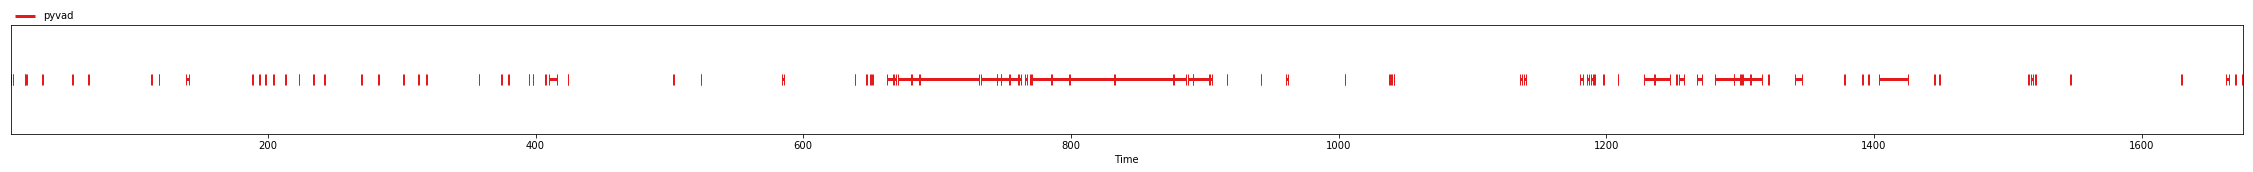

In [203]:
vad_seg_an

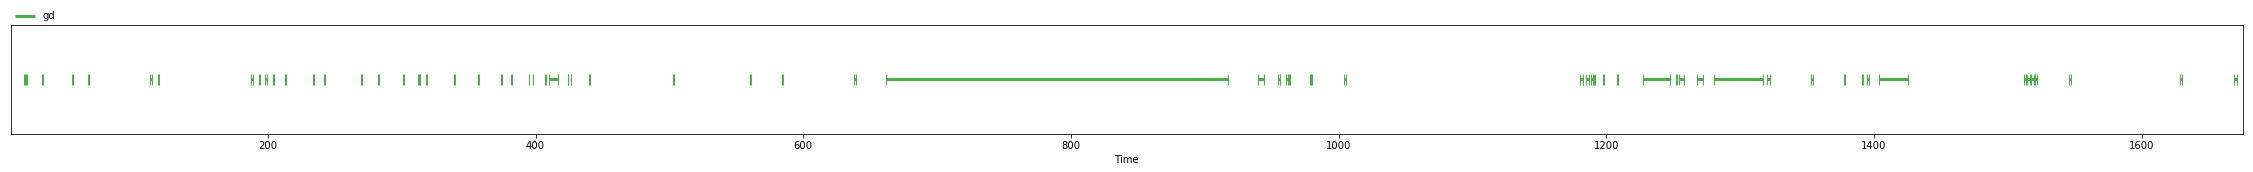

In [221]:
gd_an

In [89]:
from pyannote.metrics import detection

In [90]:
det_acc = detection.DetectionAccuracy()
det_err = detection.DetectionErrorRate()
det_cf = detection.DetectionCostFunction()

In [94]:
print('Detection accuracy:',det_acc.compute_metric(det_acc.compute_components(vad_seg_an,gd_an)))
print('Detection error rate:',det_err.compute_metric(det_err.compute_components(vad_seg_an,gd_an)))
print('Detection cost function:',det_cf.compute_metric(det_cf.compute_components(vad_seg_an,gd_an)))

Detection accuracy: 0.9443070805453685
Detection error rate: 0.25243702478729363
Detection cost function: 0.061424020959540235


## Analysis of VAD for all participants

In [110]:


all_an = Annotation()
for i in range(shashi_segments.shape[0]):
    record = shashi_segments.loc[i,:]
    all_an[Segment(record['start'], record['end']), '1'] = 'shashi'
for i in range(luis_segments.shape[0]):
    record = luis_segments.loc[i,:]
    all_an[Segment(record['start'], record['end']), '2'] = 'luis'
for i in range(pankaj_segments.shape[0]):
    record = pankaj_segments.loc[i,:]
    all_an[Segment(record['start'], record['end']), '3'] = 'pankaj'
for i in range(chus_segments.shape[0]):
    record = chus_segments.loc[i,:]
    all_an[Segment(record['start'], record['end']), '4'] = 'chus'

In [116]:
chart = all_an.chart(percent=True)

In [125]:
x = [i for i in range(len(chart))]
labels = [i[0] for i in chart]

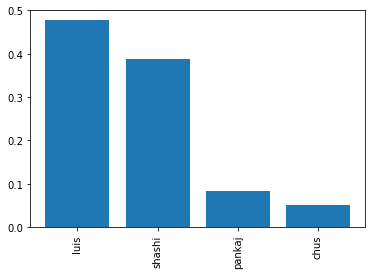

In [128]:
plt.bar(x,[i[1] for i in chart])
plt.xticks(x, labels, rotation='vertical')
plt.show()

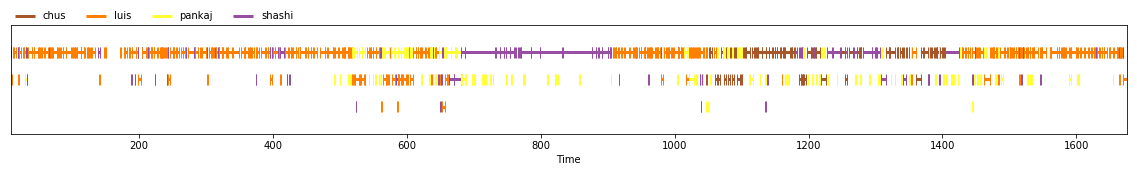

In [129]:
all_an

In above figure, voice activity for pankaj is wrongly detected. Actually, there was a person speaking however that was detected for pankaj's voice. This is the case which highlight the issue with voice activity-based detection methods.

In [131]:
t = all_an.get_timeline()

In [139]:
a,b = t.overlapping(600)
print(a,b)

[ 00:09:58.710 -->  00:10:00.270] [ 00:09:59.700 -->  00:10:02.220]


In [193]:
timelines = {}
timelines['luis'] = all_an.label_timeline('luis')
timelines['pankaj'] = all_an.label_timeline('pankaj')
timelines['shashi'] = all_an.label_timeline('shashi')
timelines['chus'] = all_an.label_timeline('chus')


In [208]:
# luis pankaj overlap
overlap_all = Annotation()
overlap_annotations = {}
for group in combinations(['luis','pankaj','chus','shashi'],2):
    key = '_'.join(group)
    print(key)
    if key not in overlap_annotations.keys():
        overlap_annotations[key] = Annotation()
    for seg1,seg2 in timelines[group[0]].co_iter(timelines[group[1]]):
        inter = seg1 & seg2
        overlap_annotations[key][inter] = key
        overlap_all[inter] = key
        timeline.add(inter)
   

luis_pankaj
luis_chus
luis_shashi
pankaj_chus
pankaj_shashi
chus_shashi


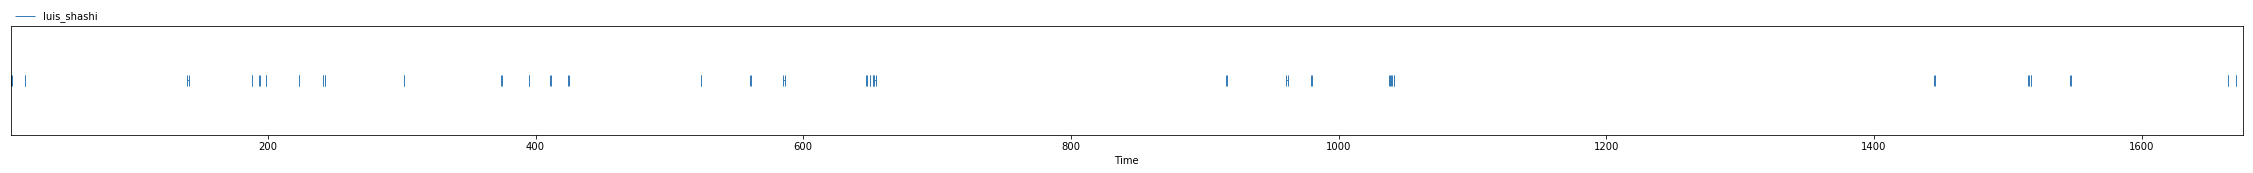

In [204]:
overlap_annotations['luis_shashi']

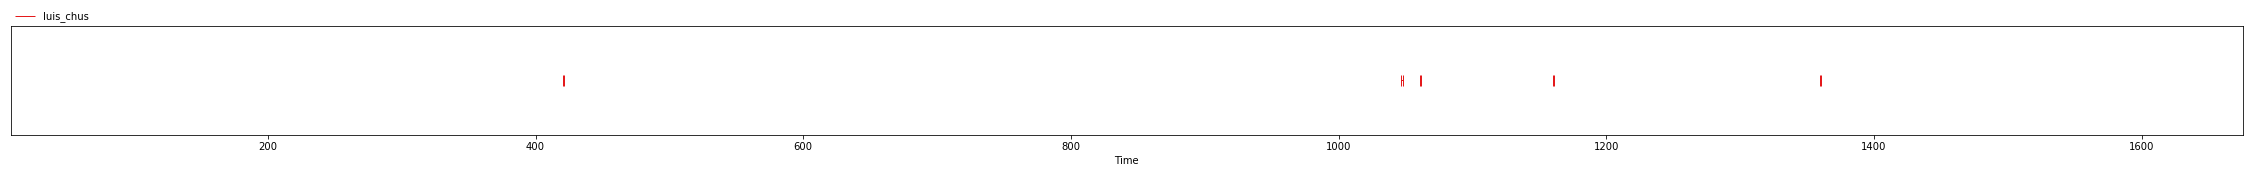

In [205]:
overlap_annotations['luis_chus']

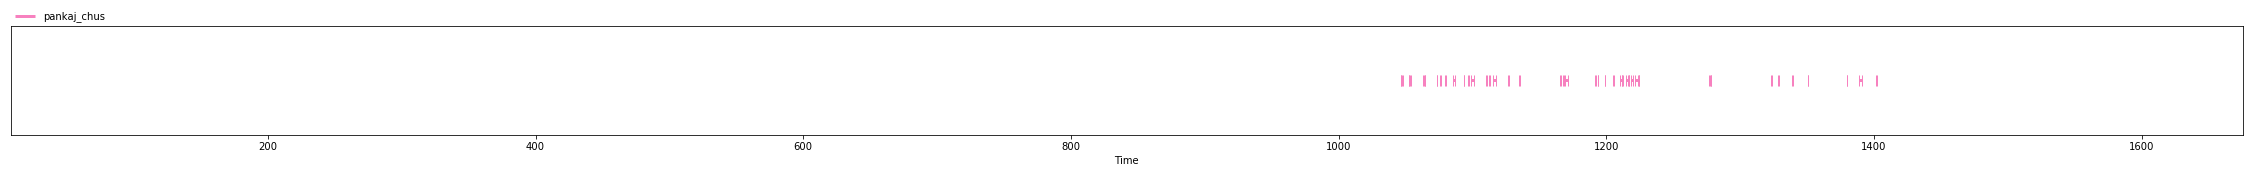

In [206]:
overlap_annotations['pankaj_chus']

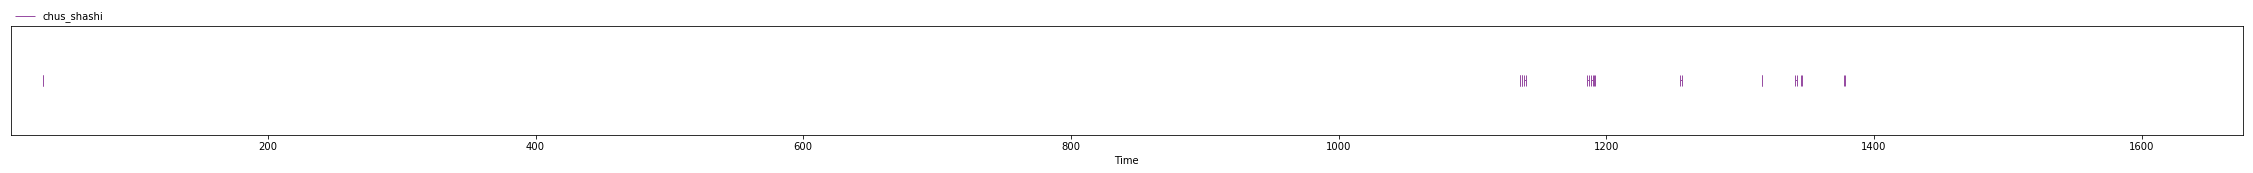

In [207]:
overlap_annotations['chus_shashi']

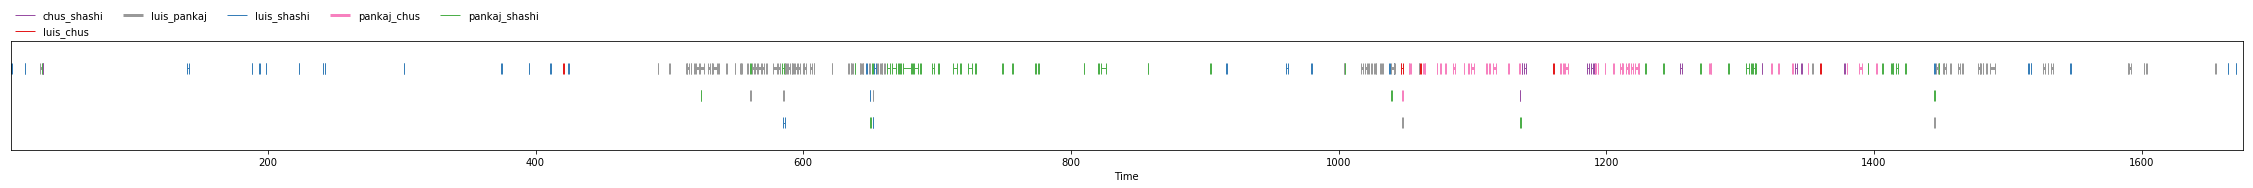

In [209]:
overlap_all

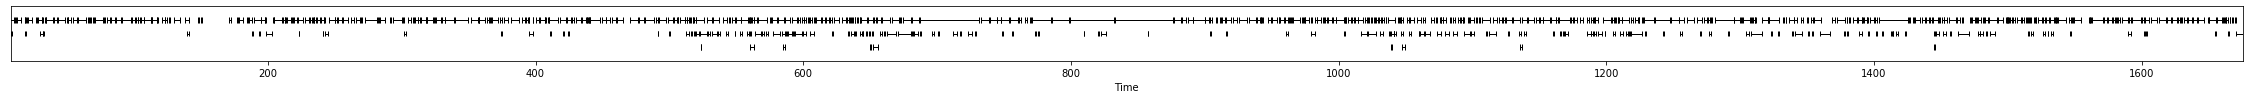

In [227]:
# Compute Turn Taking for each participants
all_an.get_timeline()

In [237]:
t = all_an.get_timeline()
s =t[len(t)-1]
print(s)
print(s.end)

[ 01:08:22.950 -->  01:08:23.610]
4103.610000011974


# Feature Extraction for 30 seconds window
This part of the code will extract features from the VAD results.


In [239]:
def to_dataframe(annotations):
    df = pd.DataFrame(columns=['start','end','label'])
    for segment, _, label in all_an.itertracks(yield_label=True):
        df = df.append({'start':segment.start,'end':segment.end,'label':label},ignore_index=True)
    return df

In [241]:
dd = to_dataframe(all_an)

In [244]:
dd['start'] = pd.to_datetime(dd['start'], unit='s')

In [248]:
dd.iloc[-1,0]

Timestamp('1970-01-01 01:08:22.950000012')

In [315]:
def verbalFeatures(anno,window_size='30S'):
    chart = anno.chart(percent=True)
    labels = [i[0] for i in chart]
    timelines = {}
    for label in labels:
        timelines[label] = anno.label_timeline(label)
    
    df = pd.DataFrame(columns=['start','end','label'])
    for segment, _, label in all_an.itertracks(yield_label=True):
        df = df.append({'start':segment.start,'end':segment.end,'label':label},ignore_index=True)
    df['duration'] = df['end'] - df['start']
    df['start'] = pd.to_datetime(df['start'], unit='s')
    df['end'] = pd.to_datetime(df['end'], unit='s')
    # Setting the index
    df = df.set_index(pd.DatetimeIndex(df['start']))
    
    columns=['frame']
    
    for label in labels:
        col_name = label+'_speak'
        columns.append(col_name)
        
    for label in labels:
        col_name = label+'_turns'
        columns.append(col_name)
    
    final = pd.DataFrame()
    

    
    # End time to stop loop
    end_time = df.iloc[-1,0]
    start_time = df.iloc[0,0]
    
    
    frame_no = 1
    cur_ts = start_time
    
    # Creating time delta from specified time window
    time_delta = pd.to_timedelta(window_size)
    
    frame_no = 1
    
    while cur_ts < end_time:
        # Computing the end of timewindow
        next_ts = cur_ts + time_delta
        
        print('Frame:',frame_no)

        # Getting data between two timestamps
        temp_speech_df = df.between_time(datetime.datetime.time(cur_ts),datetime.datetime.time(next_ts),include_start=True,include_end=False)

        # Generate features out of the data
        entry = extractFeatures(frame_no,labels,start_time,cur_ts,temp_speech_df)

        # Adding the entry to the dataframe
        final = final.append(entry,ignore_index=True)

        # Moving starting timestamp to next time window
        cur_ts = next_ts

        frame_no += 1
        
    return final

def extractFeatures(frame,labels,start_time,timestamp,speech_df):  
    speak_time = {}
    for label in labels:
        speak_time[label] = 0
        us = speech_df.loc[speech_df['label']==label,:]
        speak_time[label] = us.duration.sum()

    # String to store the speaking sequence
    speaking_sequence=""

    
    
    # Speaking sequence
    sequence = speech_df['label'].tolist()

    
    result = {'frame':frame}
    
    for label in labels:
        speak_label = label + '_speak'
        result[speak_label] = speak_time[label]
        
    
    
    # For computing turn-taking  
    turn_df = pd.DataFrame(columns=['label','conti_frequency'])

    # This function will count the number of continuous occurence
    def count_conti_occurence(index):

        # Set count to 0
        count=0

        # Starts from the given index
        j = index

        # Loop to iterate over the users sequence
        while j<len(sequence):

            # Increase the count if the element at given index (parameter) is same as the iterated element
            if sequence[j] == sequence[index]:
                count +=1

            # If mismatch found, break the loop
            else:
                break

            # Increases j
            j +=1

        # Return number of count for sequence[index] and index of first next occurence of different element.
        return count,(j-index)

    # Set i to 0 for the Loop
    i = 0

    # Iterate for entire sequence of users
    while i < len(sequence):

        # Call count_conti_occurence() function
        count,diff = count_conti_occurence(i)


        # Add continuous frequency of current user (sequence[i]) to the dataframe
        turn_df = turn_df.append({'label':sequence[i],'conti_frequency':count},ignore_index=True)


        # Move to next different element
        i = i + diff
    
    for label in labels:
        turn_label = label + '_turns'
        turns = turn_df.loc[turn_df['label']==label,:]
        
        result[turn_label] = turns.shape[0]
    
    
    
    anno = Annotation()
    for index, record in speech_df.iterrows():      
        start = (record['start'] - start_time).total_seconds()       
        end = (record['end'] - start_time).total_seconds()
        anno[Segment(start, end), '_'] = record['label']
        
    for label1 in labels:
        #print('Label:',label1)
        overlap_label = label1+'_overlap'
        overlap_time = 0
        for label2 in labels:
            if label1 != label2:
                #print('-->',label2)
                label1_timeline = anno.label_timeline(label1)
                label2_timeline = anno.label_timeline(label2)
                
                for seg1,seg2 in label1_timeline.co_iter(label2_timeline):
                    #print('=====>',seg1,seg2,)
                    #print('      ',(seg1 & seg2).duration)
                    overlap_time += (seg1 & seg2).duration
        result[overlap_label] = overlap_time
    
    return result            

In [316]:
f = verbalFeatures(all_an)

Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
Frame: 16
Frame: 17
Frame: 18
Frame: 19
Frame: 20
Frame: 21
Frame: 22
Frame: 23
Frame: 24
Frame: 25
Frame: 26
Frame: 27
Frame: 28
Frame: 29
Frame: 30
Frame: 31
Frame: 32
Frame: 33
Frame: 34
Frame: 35
Frame: 36
Frame: 37
Frame: 38
Frame: 39
Frame: 40
Frame: 41
Frame: 42
Frame: 43
Frame: 44
Frame: 45
Frame: 46
Frame: 47
Frame: 48
Frame: 49
Frame: 50
Frame: 51
Frame: 52
Frame: 53
Frame: 54
Frame: 55
Frame: 56
Frame: 57
Frame: 58
Frame: 59
Frame: 60
Frame: 61
Frame: 62
Frame: 63
Frame: 64
Frame: 65
Frame: 66
Frame: 67
Frame: 68
Frame: 69
Frame: 70
Frame: 71
Frame: 72
Frame: 73
Frame: 74
Frame: 75
Frame: 76
Frame: 77
Frame: 78
Frame: 79
Frame: 80
Frame: 81
Frame: 82
Frame: 83
Frame: 84
Frame: 85
Frame: 86
Frame: 87
Frame: 88
Frame: 89
Frame: 90
Frame: 91
Frame: 92
Frame: 93
Frame: 94
Frame: 95
Frame: 96
Frame: 97
Frame: 98
Frame: 99
Frame: 100
Frame: 1

In [317]:
f

,chus_overlap,chus_speak,chus_turns,frame,luis_overlap,luis_speak,luis_turns,pankaj_overlap,pankaj_speak,pankaj_turns,shashi_overlap,shashi_speak,shashi_turns
0,0.00,0.00,0.0,1.0,2.34,20.58,4.0,1.53,1.98,1.0,0.81,1.65,3.0
1,0.09,0.75,1.0,2.0,0.00,23.97,1.0,0.00,0.81,1.0,0.09,0.81,1.0
2,0.00,0.00,0.0,3.0,0.00,24.75,1.0,0.00,0.00,0.0,0.00,0.45,1.0
3,0.00,0.00,0.0,4.0,0.00,16.08,2.0,0.00,0.00,0.0,0.00,0.51,1.0
4,0.00,0.00,0.0,5.0,0.99,10.71,2.0,0.00,0.00,0.0,0.99,3.12,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,0.00,0.00,0.0,133.0,27.09,28.41,5.0,0.00,0.00,0.0,27.09,29.52,5.0
133,0.00,0.00,0.0,134.0,14.70,16.23,5.0,0.00,0.00,0.0,14.70,20.79,5.0
134,0.00,0.00,0.0,135.0,16.62,18.99,8.0,0.00,0.00,0.0,16.62,25.59,8.0
135,0.00,0.00,0.0,136.0,10.02,10.62,2.0,0.00,0.00,0.0,10.02,19.56,3.0


# OpenFace Feature Analysis
The following code analyses the OpenFace features.

In [95]:
of = pd.read_csv('Video_11_1.csv')

In [97]:
of.face_id.unique()

array([0, 1, 2, 3])

In [98]:
shashi_of = of.loc[of.face_id == 0,:]

In [99]:
shashi_of.shape

(75150, 714)

3006.0

100%|██████████| 2/2 [00:00<00:00, 29.93it/s]

-------------------- 
 Checking multiplex edges.. 
 --------------------
-------------------- 
 Network splitting in progress 
 --------------------
BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.04  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds
Finished with layout..
Name: 
Type: MultiGraph
Number of nodes: 4
Number of edges: 2
Average degree:   1.0000
Name: 
Type: MultiGraph
Number of nodes: 4
Number of edges: 3
Average degree:   1.5000
Name: 
Type: MultiGraph
Number of nodes: 4
Number of edges: 1
Average degree:   0.5000


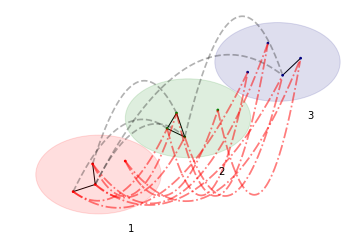

In [216]:
from py3plex.visualization.embedding_visualization import embedding_tools
from py3plex.wrappers import train_node2vec_embedding
import argparse
from collections import Counter
from py3plex.visualization.colors import colors_default
from py3plex.algorithms.community_detection import community_wrapper as cw
from py3plex.visualization.multilayer import draw_multiedges, draw_multilayer_default, hairball_plot, plt
from py3plex.core import multinet




# visualization from a simple file
multilayer_network = multinet.multi_layer_network(network_type = "multiplex").load_network(
    "edgeList.txt",input_type="multiplex_edges")
multilayer_network.visualize_network()
plt.show()